## Overview

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [154]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import *

In [3]:
plt.style.use(['dark_background'])

## Paths

In [166]:
DATA_PATH = Config.data_path()/'competitions'
PATH = DATA_PATH/'diabetic-retinopathy-detection'
CSV_PATH = PATH/'trainLabels.csv'
META_PATH = PATH/'metadata.csv'

In [5]:
PATH.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train.zip.001'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/test.zip.002'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/test.zip.006'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/test.zip.007'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/test.zip.001')]

## EDA

In [169]:
df = pd.read_csv(CSV_PATH)

In [170]:
df.iloc[22:24]

,image,level
22,30_left,1
23,30_right,2


Every image should be taken independent regardless of its id or left and right

In [171]:
df['patient'] = df.image.map(lambda x: x.split('_')[0])
df['eye'] = df.image.map(lambda x: 1 if x.split('_')[1]=='left' else 0)

In [172]:
df.head()

,image,level,patient,eye
0,10_left,0,10,1
1,10_right,0,10,0
2,13_left,0,13,1
3,13_right,0,13,0
4,15_left,1,15,1


In [173]:
df.to_feather(META_PATH)

In [177]:
import feather
df = feather.read_dataframe(META_PATH)

In [151]:
level_sum = df.groupby(['level'], as_index=False).count()
level_sum

,level,image,patient,eye
0,0,25810,25810,25810
1,1,2443,2443,2443
2,2,5292,5292,5292
3,3,873,873,873
4,4,708,708,708


In [ ]:
level_sum.plot('level','image','barh');

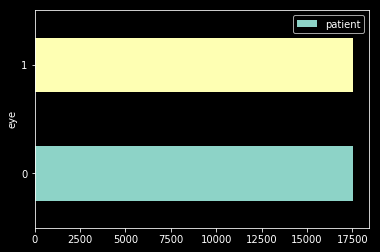

In [150]:
eye_sum = df.groupby(['eye'], as_index=False).count()
eye_sum.plot('eye', 'patient','barh');

In [9]:
id2label = {
    0 : "No DR",
    1 : "Mild",
    2 : "Moderate",
    3 : "Severe",
    4 : "Proliferative DR"}

In [10]:
label2id = {v:k for k,v in id2label.items()}; label2id

{'No DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferative DR': 4}

## Data Pipeline

In [11]:
#db0 = ImageItemList.from_csv(PATH,'trainLabels.csv', folder='train', suffix='.jpeg')

In [12]:
#db1 = db0.random_split_by_pct()

In [13]:
#db2 = db1.label_from_df()

In [14]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                    max_zoom=1, max_lighting=0.1, max_warp=0.)

In [15]:
src = (ImageItemList.from_csv(PATH,'trainLabels.csv', folder='train_512', suffix='.jpeg')
       .random_split_by_pct()
       .label_from_df()
       .add_test_folder(test_folder='test_512'))

In [16]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

## Convert

In [11]:
#folder,size = "test",512 
folder,size = "train",512
files = list((PATH/f'{folder}').glob('*.jpeg')); files[:5]

[PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/11163_left.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/35788_left.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/21602_right.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/6376_right.jpeg'),
 PosixPath('/home/jupyter/.fastai/data/competitions/diabetic-retinopathy-detection/train/14115_left.jpeg')]

In [12]:
def convert2size(fname,i):
    save_name = str(fname).replace(f'{folder}',f'{folder}_{size}')
    Path(save_name).parent.mkdir(exist_ok=True, parents=True)
    open_image(fname).resize((-1,size,size)).save(save_name)

In [13]:
parallel(convert2size,files)

## Sanity Check

In [17]:
data.sanity_check()

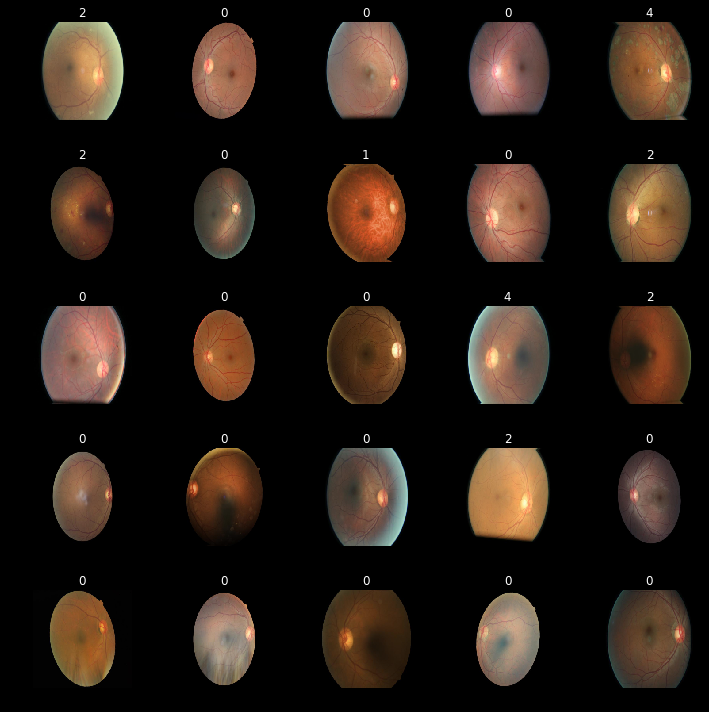

In [18]:
data.show_batch(rows=5, figsize=(10,10))

## Train

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super().__init__()
        self.alpha,self.gamma = alpha,gamma
        self.logits,self.reduct = logits,reduce
        
    def forward(self, input, target):
        
        assert (target.size() != input.size())
        
        bce_loss = (F.binary_cross_entropy_with_logits(inputs, targets, reduce=False) if
                    self.logits else F.binary_cross_entropy(inputs, targets, reduce=False))
                    
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1-pt)**self.gamma * bce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [156]:
#export
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        
        assert target.size() != input.size
        
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [157]:
arch = models.resnet50

In [158]:
learn = create_cnn(data, arch, loss_func=FocalLoss, metrics=accuracy)


In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


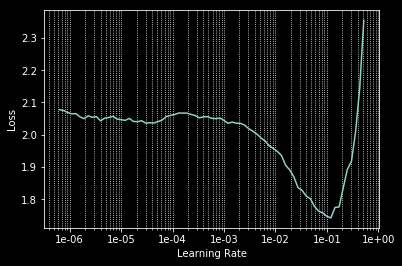

In [67]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [69]:
lr=slice(2e-2)

In [70]:
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,accuracy
1,0.800287,0.756214,0.747189
2,0.766888,0.744144,0.753310
3,0.725763,0.807888,0.765694
4,0.712523,0.730355,0.775516
5,0.685784,1.034288,0.763843
6,0.650016,0.760193,0.779786
7,0.617825,0.794960,0.794164
8,0.590323,0.732170,0.796868
9,0.550428,0.702582,0.795872
10,0.525781,0.652789,0.795730


In [71]:
learn.save('stage-1-frz-eps10-lr2en2')

In [76]:
learn.load('stage-1-frz-eps10-lr2en2');

In [77]:
learn.unfreeze()

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


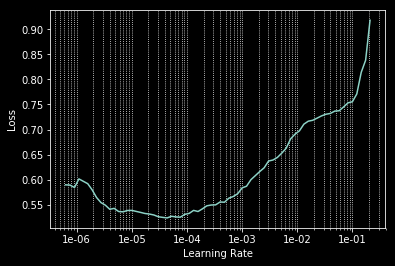

In [79]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [81]:
lrs = slice(2e-6,1e-4)

In [82]:
learn.callback_fns.append(partial(SaveModelCallback, name='stage-2-unfrz-eps10-best'))

In [ ]:
learn.fit_one_cycle(16,lrs)

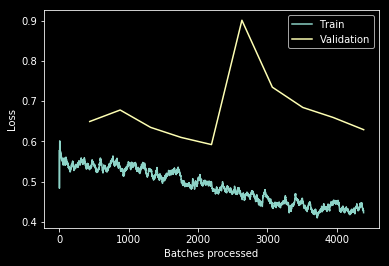

In [30]:
learn.recorder.plot_losses()

In [59]:
interp = ClassificationInterpretation.from_learner(learn)

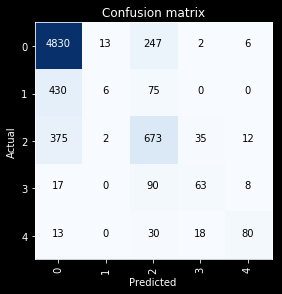

In [60]:
interp.plot_confusion_matrix()

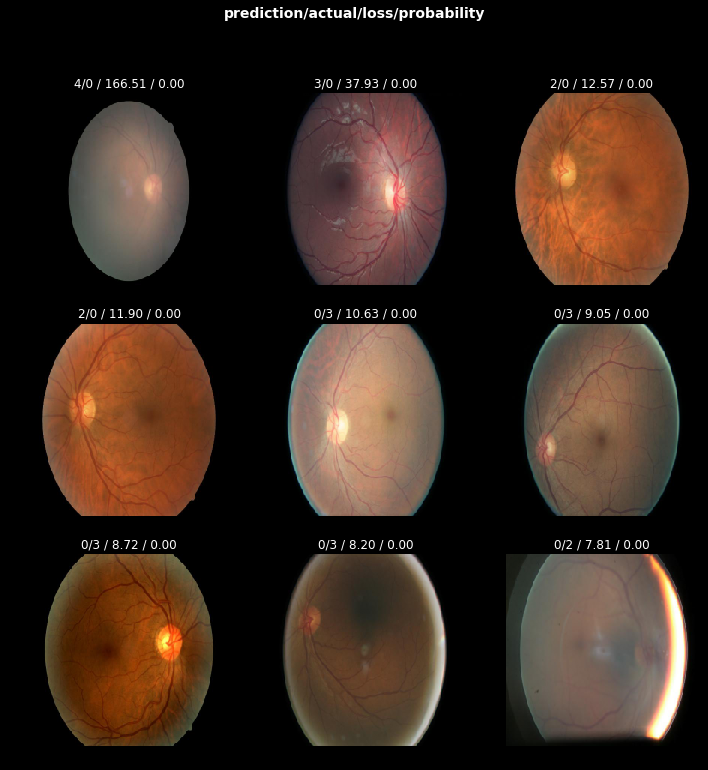

In [61]:
interp.plot_top_losses(k=9)

## Progressive Resize

In [49]:
learn.load('stage-2-unfrz-eps10-best');

In [ ]:
data = (src.transform(tfms, size=384)
        .databunch(bs=64)
        .normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [50]:
learn.freeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


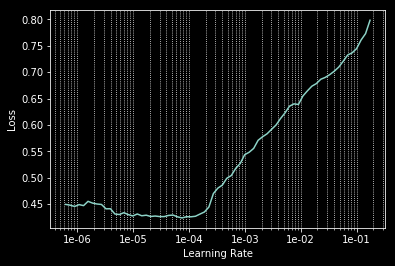

In [52]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [53]:
lrs=slice(1e-6,1e-4)

In [57]:
learn.callback_fns.append(partial(SaveModelCallback, name='stage-3-unfrz-eps12-best'))

In [58]:
learn.fit_one_cycle(12,lrs,pct_start=0.2)

epoch,train_loss,valid_loss,accuracy
1,0.425409,0.760801,0.814377
2,0.435343,0.692038,0.811388
3,0.437518,0.613263,0.804555
4,0.387478,0.973916,0.800285
5,0.326588,0.792387,0.799858
6,0.323913,0.684185,0.808968
7,0.281038,0.986962,0.801139
8,0.259745,0.800466,0.795872
9,0.239448,0.790834,0.798434
10,0.221835,0.745059,0.798861


## Interpret

## Make Prediction 

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
preds = learn.get_preds(DatasetType.Test)

In [ ]:
bool_preds = (preds[0]>0.2).numpy().astype(np.bool_)
classes = np.array(learn.data.test_ds.ds.classes)

In [ ]:
pred_dict = {fn.stem : " ".join(classes[bool_preds[i]]) for i, fn in enumerate(progress_bar(learn.data.test_ds.ds.x))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['image_name']
sub.columns = ['tags']
sub.to_csv(PATH/'submission.csv')